In [13]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

# Constants
IMG_SIZE = 256
BATCH_SIZE = 32

# Updated dataset paths:
# Previously images were separated by mode and bandwidth.
# Now all modes are together, grouped by bandwidth.
IMG_PATHS = {
    "High": "multiplexer_combined_bandwidths/combined_high_bw",
    "Low": "multiplexer_combined_bandwidths/combined_low_bw",
}

def load_images_by_bandwidth(img_paths):
    images, labels, names = [], [], []
    for bandwidth, path in img_paths.items():
        # Assign labels based on bandwidth
        label = 1 if bandwidth == "High" else 0
        count = 0  # count images loaded from this folder

        # List all files in the folder and load images
        for img_name in os.listdir(path):
            
            img_path = os.path.join(path, img_name)
            # Load the image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(label)
            names.append(img_name)
            count += 1

        print(f"Imported {count} images from {path} (bandwidth: {bandwidth})")

    # Format data for training/testing
    images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    labels = np.array(labels)
    names = np.array(names)
    return shuffle(images, labels, names, random_state=42)


# Import images using the updated scheme
images, labels, names = load_images_by_bandwidth(IMG_PATHS)

Imported 111 images from multiplexer_combined_bandwidths/combined_high_bw (bandwidth: High)
Imported 110 images from multiplexer_combined_bandwidths/combined_low_bw (bandwidth: Low)


In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# CNN model definition
def build_cnn_model():
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(2, activation="softmax"),  # Binary output for High vs Low
        ]
    )

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

2025-05-03 13:08:34.806796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746241715.297654    5415 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746241715.435812    5415 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746241716.568125    5415 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746241716.568148    5415 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746241716.568151    5415 computation_placer.cc:177] computation placer alr

In [3]:
# Train and save models for each mode
model_name = "cnn_v4_combined_model_v1"

model = build_cnn_model()
history = model.fit(x_train, y_train, epochs=20, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))
model.save(f"{model_name}.h5")

/home/maxwell/miniconda3/envs/lime/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744888652.160435 4031525 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3849 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/20


2025-04-17 21:17:33.087139: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 46137344 exceeds 10% of free system memory.
2025-04-17 21:17:33.120322: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 46137344 exceeds 10% of free system memory.
I0000 00:00:1744888654.524008 4031579 service.cc:152] XLA service 0x723240007240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744888654.524032 4031579 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-04-17 21:17:34.850774: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744888655.127035 4031579 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-17 21:17:36.238370: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially b

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4219 - loss: 4.6068

I0000 00:00:1744888663.148624 4031579 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4441 - loss: 4.9657

2025-04-17 21:17:44.332854: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.10 = (f32[16,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,127,127]{3,2,1,0} %bitcast.5347, f32[64,32,3,3]{3,2,1,0} %bitcast.4733, f32[64]{0} %bitcast.5407), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/maxwell/miniconda3/envs/lime/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-17 21:17:44.765698: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted po

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4543 - loss: 4.7757  

2025-04-17 21:17:49.519505: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.10 = (f32[32,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,127,127]{3,2,1,0} %bitcast.544, f32[64,32,3,3]{3,2,1,0} %bitcast.551, f32[64]{0} %bitcast.553), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/maxwell/miniconda3/envs/lime/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-17 21:17:50.316927: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted poten

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4617 - loss: 4.6400 - val_accuracy: 0.4667 - val_loss: 0.6504
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6141 - loss: 0.6102 - val_accuracy: 0.9556 - val_loss: 0.4879
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8938 - loss: 0.4272 - val_accuracy: 0.9778 - val_loss: 0.1880
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9495 - loss: 0.1763 - val_accuracy: 0.9556 - val_loss: 0.1189
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9589 - loss: 0.1657 - val_accuracy: 0.9333 - val_loss: 0.1620
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9265 - loss: 0.1606 - val_accuracy: 0.9778 - val_loss: 0.1514
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9563 - loss: 0.1630 - val_accuracy: 0.9556 - val_loss: 0.1101
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9791 - loss: 0.0798 - val_accuracy: 0.9556 - val_loss: 0.1191
Epoch 9/20
6

2025-04-17 21:18:03.846988: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2025-04-17 21:18:03.996525: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2025-04-17 21:18:04.057692: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.


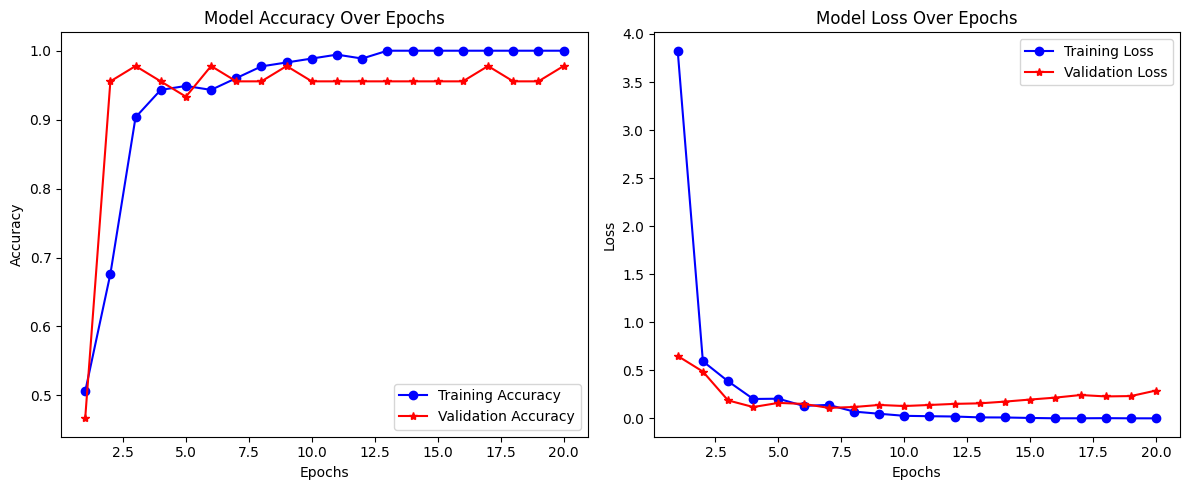

In [4]:
# ✅ Extract values from the history object
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# 🔹 Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "bo-", label="Training Accuracy")
plt.plot(epochs, val_acc, "r*-", label="Validation Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# 🔹 Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "r*-", label="Validation Loss")
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig(f"{model_name}_training_history.png")
plt.show()

In [3]:
import tensorflow as tf

model = tf.keras.models.load_model("cnn_v4_combined_model_v1.h5")
model.summary()

2026-01-29 21:01:12.794959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769684472.812861  748535 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769684472.818609  748535 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769684472.832647  748535 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769684472.832666  748535 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769684472.832668  748535 computation_placer.cc:177] computation placer alr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,660 (56.60 MB)

 Trainable params: 14,838,658 (56.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [14]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow import keras


# Optional: Suppress LIME console spam
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, "w")
        sys.stderr = open(os.devnull, "w")

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

In [23]:
import os
import shutil

folder_path = "explanations/slic_example"

# Remove exisiting explanation folders and files
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    # If it's a file, remove it
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.remove(file_path)

    # If it's a folder, remove it (and all contents) recursively
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)

print(f"All files and folders in '{folder_path}' have been deleted.")

All files and folders in 'explanations/slic_example' have been deleted.


In [24]:
def mask_average(class_dir):
    accumulated_mask = np.zeros((256, 256))
    image_count = 0
    # Accumulate mask data
    for fname in os.listdir(class_dir):
        if fname.startswith("Mask") and fname.endswith(".png"):
            mask_path = os.path.join(class_dir, fname)
            mask = plt.imread(mask_path)
            if mask.ndim == 3:
                mask = mask[:, :, 0]
            if mask.shape != (256, 256):
                continue
            accumulated_mask += mask
            image_count += 1

    avg_mask = accumulated_mask / image_count if image_count > 0 else np.zeros((256, 256))

    return avg_mask, image_count


def lime_class_heatmaps(output_dir):
    print(f"Output Directory: {output_dir}")
    print(f"Has Classes: {os.listdir(output_dir)}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    for i, lime_class in enumerate(os.listdir(output_dir)):

        # Check if it's a directory
        class_dir = os.path.join(output_dir, lime_class)

        avg_mask, image_count = mask_average(class_dir)
        
        # Average mask
        if image_count > 0:
            cbar = fig.colorbar(ax[i].imshow(avg_mask, cmap="inferno"), ax=ax[i])
            cbar.set_label("Average Importance Score")
            ax[i].set_title(f"Average Mask - {lime_class} ({image_count} images)")
            ax[i].axis("off")
  
        else:
            print(f"No valid masks found for {lime_class}")

    #plt.tight_layout()
    plt.suptitle(f"LIME Heatmap - Combined\n{output_dir}")
    plt.savefig(os.path.join("/home/maxwell/lime_paper", f"{output_dir}lime_heatmap.png"), dpi=300) 
    plt.show()
        


# Define prediction function for LIME
def predict_fn(images):
    images = images.astype("float32") / 255.0
    # Convert RGB to grayscale (LIME uses RGB)
    images = np.mean(images, axis=-1, keepdims=True)  # Shape becomes (batch, 256, 256, 1)

    # preds = model.predict(images)
    # print(f"{preds}")
    # fig, ax = plt.subplots(2,5, figsize=(8,6))
    # for i in range(10):
    #     ax[i//5, i%5].imshow(images[i])
    #     ax[i//5, i%5].axis('off')
    #     #ax[i//5, i%5].set_title(f"Pred: {round(preds[i],3)}")
    # plt.tight_layout()
    # plt.show()

    with tf.device("/GPU:0"):  # Optional, for forcing GPU
        return model.predict(images, verbose=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.550 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.486 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.631 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.566 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.716 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.532 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.628 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 10.006 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.755 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.744 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.844 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.820 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.608 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.654 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.765 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.618 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.496 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.740 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.516 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.690 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.724 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.170 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.572 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.664 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.582 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.554 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.661 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.780 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.692 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.446 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.861 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.874 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.921 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.677 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.730 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.854 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.475 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.623 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.687 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.761 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.766 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.588 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.648 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.540 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.765 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.542 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.744 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.665 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.549 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.658 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.554 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.765 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.502 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.934 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.982 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.939 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.532 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.662 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.762 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.507 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.683 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.762 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.758 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.765 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.550 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.678 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.576 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.382 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.170 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.265 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.268 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.403 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.278 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.140 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.315 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.280 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.387 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.482 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.362 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.199 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.369 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.251 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.235 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.410 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.293 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.280 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.306 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.360 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.268 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.324 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.145 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.428 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.318 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.358 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.264 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.140 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.039 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 8.880 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.306 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.111 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.433 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.450 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.411 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.426 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.186 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.273 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.204 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.396 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.410 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.312 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.310 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.290 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.166 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.186 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.329 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.198 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.335 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.341 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.284 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.217 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.159 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.102 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.174 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 8.835 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.288 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.482 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.443 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.352 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.342 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.361 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.270 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.364 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.319 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.404 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 8.884 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.215 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.128 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.234 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.039 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.204 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.274 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.285 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.423 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.249 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.260 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.258 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.106 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.536 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.541 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.512 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.529 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.521 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.486 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.475 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.271 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.388 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.245 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.433 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.377 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.392 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.466 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.137 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.325 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.376 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.265 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.199 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.286 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.331 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.349 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.315 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.104 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.511 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.659 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.499 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.472 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.434 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.355 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.226 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.287 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.285 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.378 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.478 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.466 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.284 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.288 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.276 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 8.956 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.325 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.390 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.410 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 8.936 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.229 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.243 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.221 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.147 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.599 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.436 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.544 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.445 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.583 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.198 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.326 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.417 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.414 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.376 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.540 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.002 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.458 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.385 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.354 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.211 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.306 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.312 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.332 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.214 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.074 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.257 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.281 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.258 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.400 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Iteration 220 with setting methodslic_n_segments10_compactness10_enforce_connectivityTrue and hide_color 255 took 9.120 seconds
Output Directory: explanations/slic_example/methodslic_n_segments10_compactness10_enforce_connectivityTrue_hideColor255
Has Classes: ['Class_0', 'Class_1']


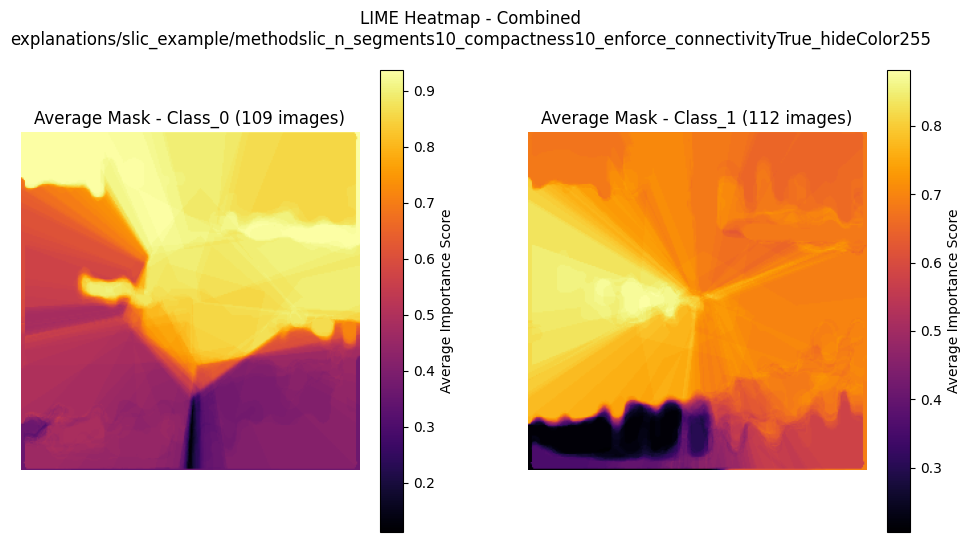

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.884 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.729 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.704 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.747 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.611 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.757 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.692 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.704 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.564 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.656 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.600 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.545 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.592 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.663 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.484 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.528 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.582 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.460 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.643 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.468 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.645 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.801 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.906 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.798 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.879 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.840 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.661 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.663 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.684 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.647 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.747 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.507 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.615 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.640 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.453 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.495 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.552 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.584 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.544 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.472 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.412 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.641 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.596 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.408 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.343 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.048 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 11.001 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.896 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.780 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.920 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.705 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.628 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.653 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.779 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.619 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.543 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.615 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.628 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.674 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.525 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.538 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.507 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.482 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.392 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.562 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.562 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.566 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.422 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.548 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.889 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.868 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.814 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.641 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.556 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.680 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.606 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.677 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.565 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.732 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.576 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.616 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.743 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.534 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.506 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.589 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.457 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.558 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.489 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.451 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.593 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.521 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.426 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.468 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.682 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.753 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.976 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.814 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.641 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.678 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.829 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.729 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.766 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.737 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.598 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.587 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.638 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.455 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.537 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.492 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.615 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.638 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.496 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.546 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.621 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.527 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.493 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.422 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.392 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.985 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.900 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.776 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.817 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.859 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.694 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.721 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.677 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.842 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.560 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.707 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.782 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.578 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.473 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.626 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.469 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.455 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.609 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.477 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.661 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.480 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.598 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.591 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.408 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.743 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.876 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.882 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.842 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.825 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.715 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.837 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.702 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.674 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.689 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.572 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.630 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.659 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.699 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.614 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.512 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.431 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.671 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.524 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.512 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.522 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.505 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.613 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.528 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.349 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.684 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.774 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.807 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.820 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.859 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.642 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.830 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.642 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.733 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.567 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.588 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.808 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.601 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.612 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.515 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.608 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.561 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.610 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.653 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.562 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.459 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.456 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.383 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.432 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.541 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.993 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.899 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.868 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.877 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.650 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.828 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.804 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.664 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.643 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.775 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.699 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.631 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.527 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.653 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.517 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.536 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.638 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.547 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.589 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.642 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.477 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.484 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.540 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.490 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.447 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.904 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.912 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.800 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Iteration 220 with setting methodslic_n_segments100_compactness10_enforce_connectivityTrue and hide_color 255 took 10.761 seconds
Output Directory: explanations/slic_example/methodslic_n_segments100_compactness10_enforce_connectivityTrue_hideColor255
Has Classes: ['Class_0', 'Class_1']


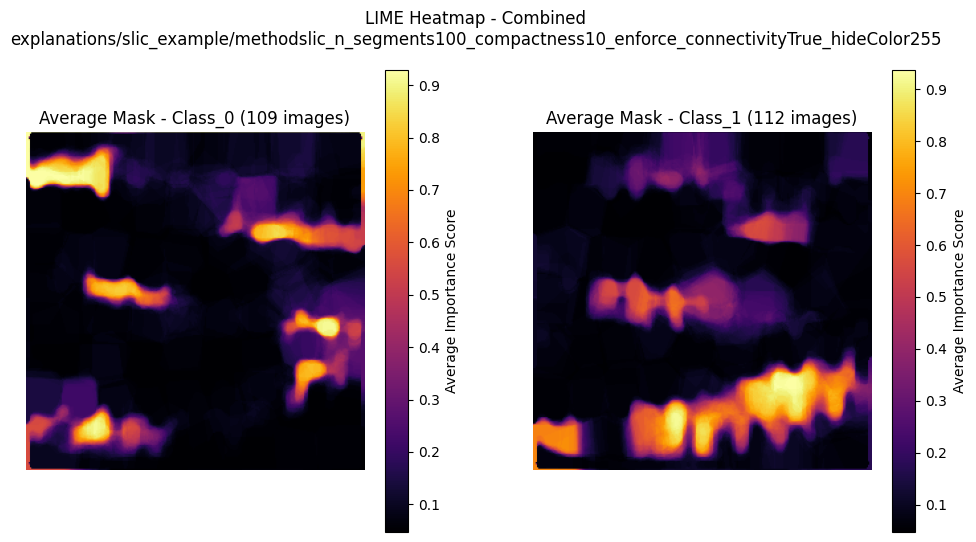

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.960 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 1 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.818 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 2 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.729 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 3 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.075 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 4 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.663 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 5 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.953 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 6 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.854 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 7 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.880 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 8 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.611 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 9 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.998 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 10 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.733 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 11 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.857 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 12 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.790 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 13 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.763 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 14 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.607 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 15 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.799 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 16 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.616 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 17 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.666 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 18 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.660 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 19 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.961 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 20 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.048 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 21 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.007 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 22 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.126 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 23 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.941 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 24 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.994 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.980 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 26 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.778 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 27 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.856 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 28 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.683 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 29 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.708 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 30 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.820 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 31 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.743 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 32 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.703 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 33 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.795 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 34 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.739 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 35 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.565 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 36 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.651 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 37 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.859 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 38 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.742 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 39 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.837 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 40 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.578 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 41 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.055 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 42 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.679 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 43 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.577 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 44 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.827 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 45 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.126 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 46 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.258 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 47 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.285 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 48 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.146 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 49 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.197 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 50 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.257 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 51 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.875 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 52 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.796 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 53 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.973 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 54 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.780 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 55 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.867 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 56 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.782 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 57 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.854 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 58 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.984 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 59 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.835 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 60 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.908 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 61 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.727 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 62 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.712 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 63 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.746 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 64 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.772 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 65 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.868 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 66 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.844 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 67 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.657 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 68 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.769 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 69 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.018 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 70 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.347 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 71 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.890 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 72 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.067 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 73 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.945 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 74 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.791 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 75 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.806 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 76 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.735 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 77 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.899 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 78 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.852 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 79 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.934 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 80 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.876 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 81 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.898 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 82 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.733 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 83 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.729 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 84 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.824 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 85 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.703 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 86 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.986 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 87 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.689 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 88 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.817 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 89 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.893 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 90 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.697 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 91 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.520 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 92 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.723 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 93 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.771 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 94 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.673 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 95 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.093 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 96 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.147 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 97 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.128 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 98 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.937 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.041 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.121 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 101 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.956 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 102 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.991 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 103 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.840 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 104 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.836 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 105 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.021 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 106 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.887 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 107 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.699 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 108 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.833 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 109 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.840 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 110 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.995 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 111 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.725 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 112 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.759 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 113 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.901 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 114 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.930 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 115 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.787 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 116 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.597 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 117 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.598 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 118 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.610 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.541 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 120 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.086 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 121 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.062 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 122 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.281 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 123 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.990 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 124 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.004 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 125 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.104 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 126 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.032 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 127 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.021 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 128 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.981 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 129 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.979 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 130 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.921 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 131 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.773 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 132 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.972 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 133 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.912 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 134 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.745 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 135 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.992 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 136 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.862 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 137 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.913 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 138 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.960 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.892 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 140 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.972 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 141 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.736 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 142 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.760 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 143 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.806 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 144 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.598 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 145 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.523 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 146 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.370 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 147 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.967 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 148 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.211 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 149 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.264 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 150 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.024 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 151 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.857 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 152 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.913 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 153 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.992 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 154 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.037 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 155 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.112 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 156 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.727 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 157 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.817 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 158 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.673 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.791 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 160 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.841 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 161 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.771 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 162 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.731 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 163 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.776 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 164 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.003 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 165 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.988 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 166 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.623 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 167 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.659 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 168 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.536 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 169 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.518 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 170 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.606 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 171 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.173 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 172 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.099 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 173 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.254 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 174 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.941 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 175 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.087 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 176 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.079 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 177 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.870 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 178 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.049 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 179 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.907 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 180 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.833 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 181 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.806 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 182 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.862 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 183 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.801 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 184 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.962 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 185 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.957 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 186 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.733 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 187 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.638 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 188 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.835 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 189 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.632 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 190 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.785 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 191 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.828 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 192 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.774 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 193 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.845 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 194 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.827 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 195 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.950 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 196 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.698 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 197 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.215 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 198 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.158 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.202 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 200 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.916 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 201 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.265 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 202 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.120 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 203 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.039 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 204 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.923 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 205 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.808 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 206 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.768 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 207 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.829 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 208 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.822 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 209 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.866 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 210 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.931 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 211 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.871 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 212 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 12.040 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 213 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.711 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 214 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.824 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 215 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.874 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 216 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.688 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 217 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.880 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 218 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.895 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 219 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.617 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Iteration 220 with setting methodslic_n_segments200_compactness10_enforce_connectivityTrue and hide_color 255 took 11.569 seconds
Output Directory: explanations/slic_example/methodslic_n_segments200_compactness10_enforce_connectivityTrue_hideColor255
Has Classes: ['Class_0', 'Class_1']


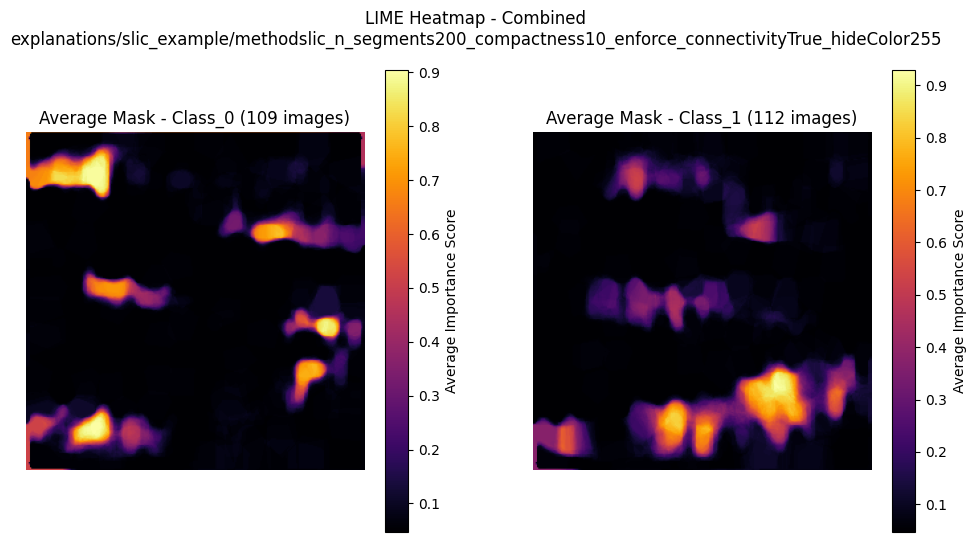

In [25]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
import time

explainer = lime_image.LimeImageExplainer()

# Define LIME segmentation settings
lime_settings = [
    {"method": "slic", "n_segments": 10, "compactness": 10, "enforce_connectivity": True},
    {"method": "slic", "n_segments": 100, "compactness": 10, "enforce_connectivity": True},
    {"method": "slic", "n_segments": 200, "compactness": 10, "enforce_connectivity": True},
]

# Define different hide_color settings
hide_colors = [255]  # Example: black, gray, white

# Loop over LIME settings and hide_color values
for setting in lime_settings:
    for hide_color in hide_colors:
        # Create a segmentation algorithm with the current setting
        segmenter = SegmentationAlgorithm(setting["method"], **{k: v for k, v in setting.items() if k != "method"})
        
        # Create an output directory for the current setting and hide_color
        setting_name = "_".join(f"{k}{v}" for k, v in setting.items())
        output_dir = f"explanations/slic_example/{setting_name}_hideColor{hide_color}"
        os.makedirs(output_dir, exist_ok=True)
        
        for i, image in enumerate(images):
            start_time = time.time()
            sample_image = (image * 255).astype("uint8")
            if sample_image.shape[-1] == 1:
                sample_image = np.repeat(sample_image, 3, axis=-1)

            with SuppressOutput():
                explanation = explainer.explain_instance(
                    sample_image.astype("double"),
                    predict_fn,
                    segmentation_fn=segmenter,
                    top_labels=1,
                    hide_color=hide_color,
                    num_samples=1000,
                )

            predicted_class = np.argmax(model.predict(image.reshape(1, 256, 256, 1)))
            temp, mask = explanation.get_image_and_mask(predicted_class, positive_only=True, num_features=10, hide_rest=False)

            class_folder = os.path.join(output_dir, f"Class_{predicted_class}")
            os.makedirs(class_folder, exist_ok=True)

            # Save original
            plt.imsave(os.path.join(class_folder, f"Original_{i}_{names[i]}.png"), sample_image[:, :, 0], cmap="gray")
            # Save explanation
            plt.imsave(
                os.path.join(class_folder, f"LIME_Explanation_{i}.png"), mark_boundaries(temp / 255.0, mask, color=(1, 1, 0))
            )
            # Save mask
            plt.imsave(os.path.join(class_folder, f"Mask_{i}.png"), mask, cmap="plasma")

            elapsed = time.time() - start_time
            print(f"Iteration {i} with setting {setting_name} and hide_color {hide_color} took {elapsed:.3f} seconds")

        lime_class_heatmaps(output_dir)